# Synthetic Dataset Generation for Credit Scoring

This notebook generates a synthetic dataset that simulates lead conversion data for credit scoring analysis.

## Dataset Features

The dataset includes the following variables:
- **monthly_income**: Monthly income in MXN (3,000 to 50,000)
- **employment_tenure**: Months in current employment (0 to 360)
- **age**: Age in years (18 to 70)
- **employment_type**: Type of employment (Salaried, Self-employed, Retired, Other)
- **acquisition_channel**: How the lead was acquired (Digital, Branch, Referral, Phone)
- **marital_status**: Marital status (Single, Married, Divorced, Widowed)
- **gender**: Gender (M, F)
- **converted**: Target variable (0 = not converted, 1 = converted)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Define Data Generation Functions

In [ ]:
def generate_monthly_income(n: int) -> np.ndarray:
    """
    Generate monthly income following a log-normal distribution.
    This creates a realistic income distribution with right skew.
    """
    # Log-normal distribution parameters for realistic income
    mu = 9.8  # Mean of log(income)
    sigma = 0.6  # Std of log(income)
    
    income = np.random.lognormal(mu, sigma, n)
    # Clip to reasonable range
    return np.clip(income, 3000, 50000)


def generate_employment_tenure(n: int) -> np.ndarray:
    """
    Generate employment tenure with exponential distribution.
    Most people have shorter tenure, fewer have very long tenure.
    """
    # Exponential with mean around 60 months
    tenure = np.random.exponential(scale=60, size=n)
    return np.clip(tenure, 0, 360).astype(int)


def generate_age(n: int) -> np.ndarray:
    """
    Generate age with normal distribution centered at 38 years.
    """
    age = np.random.normal(loc=38, scale=12, size=n)
    return np.clip(age, 18, 70).astype(int)


def generate_categorical(n: int, categories: list, probabilities: list) -> np.ndarray:
    """
    Generate categorical variable with specified probabilities.
    """
    return np.random.choice(categories, size=n, p=probabilities)


def calculate_conversion_probability(
    income: np.ndarray,
    tenure: np.ndarray,
    age: np.ndarray,
    employment_type: np.ndarray,
    channel: np.ndarray
) -> np.ndarray:
    """
    Calculate conversion probability based on features.
    This creates realistic relationships between features and conversion.
    Configured for highly imbalanced dataset (~1.5% conversion rate).
    """
    # Base probability (reduced for imbalanced dataset)
    base_prob = 0.005
    
    # Income effect (normalized and scaled down)
    income_effect = (income - 3000) / (50000 - 3000) * 0.015
    
    # Tenure effect (normalized and scaled down)
    tenure_effect = np.minimum(tenure / 180, 1.0) * 0.008
    
    # Age effect (quadratic - peak at 40 years, scaled down)
    age_normalized = (age - 18) / (70 - 18)
    age_effect = 0.006 * (1 - 4 * (age_normalized - 0.5) ** 2)
    
    # Employment type effect (scaled down)
    employment_effect = np.zeros(len(income))
    employment_effect[employment_type == 'Salaried'] = 0.004
    employment_effect[employment_type == 'Self-employed'] = -0.002
    employment_effect[employment_type == 'Retired'] = 0.002
    employment_effect[employment_type == 'Other'] = -0.004
    
    # Channel effect (scaled down)
    channel_effect = np.zeros(len(income))
    channel_effect[channel == 'Referral'] = 0.005
    channel_effect[channel == 'Branch'] = 0.003
    channel_effect[channel == 'Digital'] = 0.001
    channel_effect[channel == 'Phone'] = -0.002
    
    # Combine all effects
    total_prob = (
        base_prob +
        income_effect +
        tenure_effect +
        age_effect +
        employment_effect +
        channel_effect
    )
    
    # Ensure probabilities are in [0, 1]
    return np.clip(total_prob, 0, 1)


def generate_conversion(
    probabilities: np.ndarray,
    noise: float = 0.05
) -> np.ndarray:
    """
    Generate binary conversion outcome based on probabilities.
    Adds small random noise to simulate real-world randomness.
    """
    # Add noise
    noisy_probs = probabilities + np.random.normal(0, noise, len(probabilities))
    noisy_probs = np.clip(noisy_probs, 0, 1)
    
    # Generate binary outcomes
    return (np.random.random(len(probabilities)) < noisy_probs).astype(int)

## 2. Generate Dataset

In [3]:
# Dataset size
n_samples = 5000

# Generate continuous variables
monthly_income = generate_monthly_income(n_samples)
employment_tenure = generate_employment_tenure(n_samples)
age = generate_age(n_samples)

# Generate categorical variables
employment_type = generate_categorical(
    n_samples,
    categories=['Salaried', 'Self-employed', 'Retired', 'Other'],
    probabilities=[0.50, 0.30, 0.10, 0.10]
)

acquisition_channel = generate_categorical(
    n_samples,
    categories=['Digital', 'Branch', 'Referral', 'Phone'],
    probabilities=[0.40, 0.30, 0.20, 0.10]
)

marital_status = generate_categorical(
    n_samples,
    categories=['Single', 'Married', 'Divorced', 'Widowed'],
    probabilities=[0.35, 0.45, 0.15, 0.05]
)

gender = generate_categorical(
    n_samples,
    categories=['M', 'F'],
    probabilities=[0.52, 0.48]
)

# Calculate conversion probabilities and generate outcomes
conversion_probs = calculate_conversion_probability(
    monthly_income,
    employment_tenure,
    age,
    employment_type,
    acquisition_channel
)

converted = generate_conversion(conversion_probs)

# Create DataFrame
df = pd.DataFrame({
    'monthly_income': monthly_income,
    'employment_tenure': employment_tenure,
    'age': age,
    'employment_type': employment_type,
    'acquisition_channel': acquisition_channel,
    'marital_status': marital_status,
    'gender': gender,
    'converted': converted
})

print(f"Dataset shape: {df.shape}")
print(f"\nConversion rate: {df['converted'].mean():.2%}")
print(f"Number of conversions: {df['converted'].sum()}")
print(f"Number of non-conversions: {(1 - df['converted']).sum()}")

Dataset shape: (5000, 8)

Conversion rate: 54.86%
Number of conversions: 2743
Number of non-conversions: 2257


## 3. Explore Dataset

In [4]:
# Display first rows
print("First 10 rows:")
display(df.head(10))

# Summary statistics
print("\nSummary statistics:")
display(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

First 10 rows:


,monthly_income,employment_tenure,age,employment_type,acquisition_channel,marital_status,gender,converted
0,24295.064260,11,26,Self-employed,Branch,Divorced,M,0
1,16598.065299,12,31,Self-employed,Branch,Single,F,0
2,26598.580345,37,34,Self-employed,Digital,Single,M,0
3,44973.014624,20,50,Salaried,Digital,Married,M,1
4,15670.072706,17,24,Self-employed,Branch,Married,F,0
5,15670.227067,62,33,Salaried,Referral,Married,M,1
6,46514.886927,63,49,Self-employed,Referral,Single,F,0
7,28579.953872,104,34,Self-employed,Digital,Single,F,1
8,13606.669670,32,43,Self-employed,Referral,Married,M,1
9,24972.638042,4,36,Salaried,Digital,Divorced,M,0



Summary statistics:


,monthly_income,employment_tenure,age,converted
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,20936.023614,57.559200,37.793400,0.548600
std,11664.845590,56.397938,11.311512,0.497682
min,3000.000000,0.000000,18.000000,0.000000
25%,12152.096436,17.000000,30.000000,0.000000
50%,18180.036835,40.000000,38.000000,1.000000
75%,26892.598210,80.000000,45.000000,1.000000
max,50000.000000,360.000000,70.000000,1.000000



Missing values:
monthly_income         0
employment_tenure      0
age                    0
employment_type        0
acquisition_channel    0
marital_status         0
gender                 0
converted              0
dtype: int64


## 4. Visualize Dataset

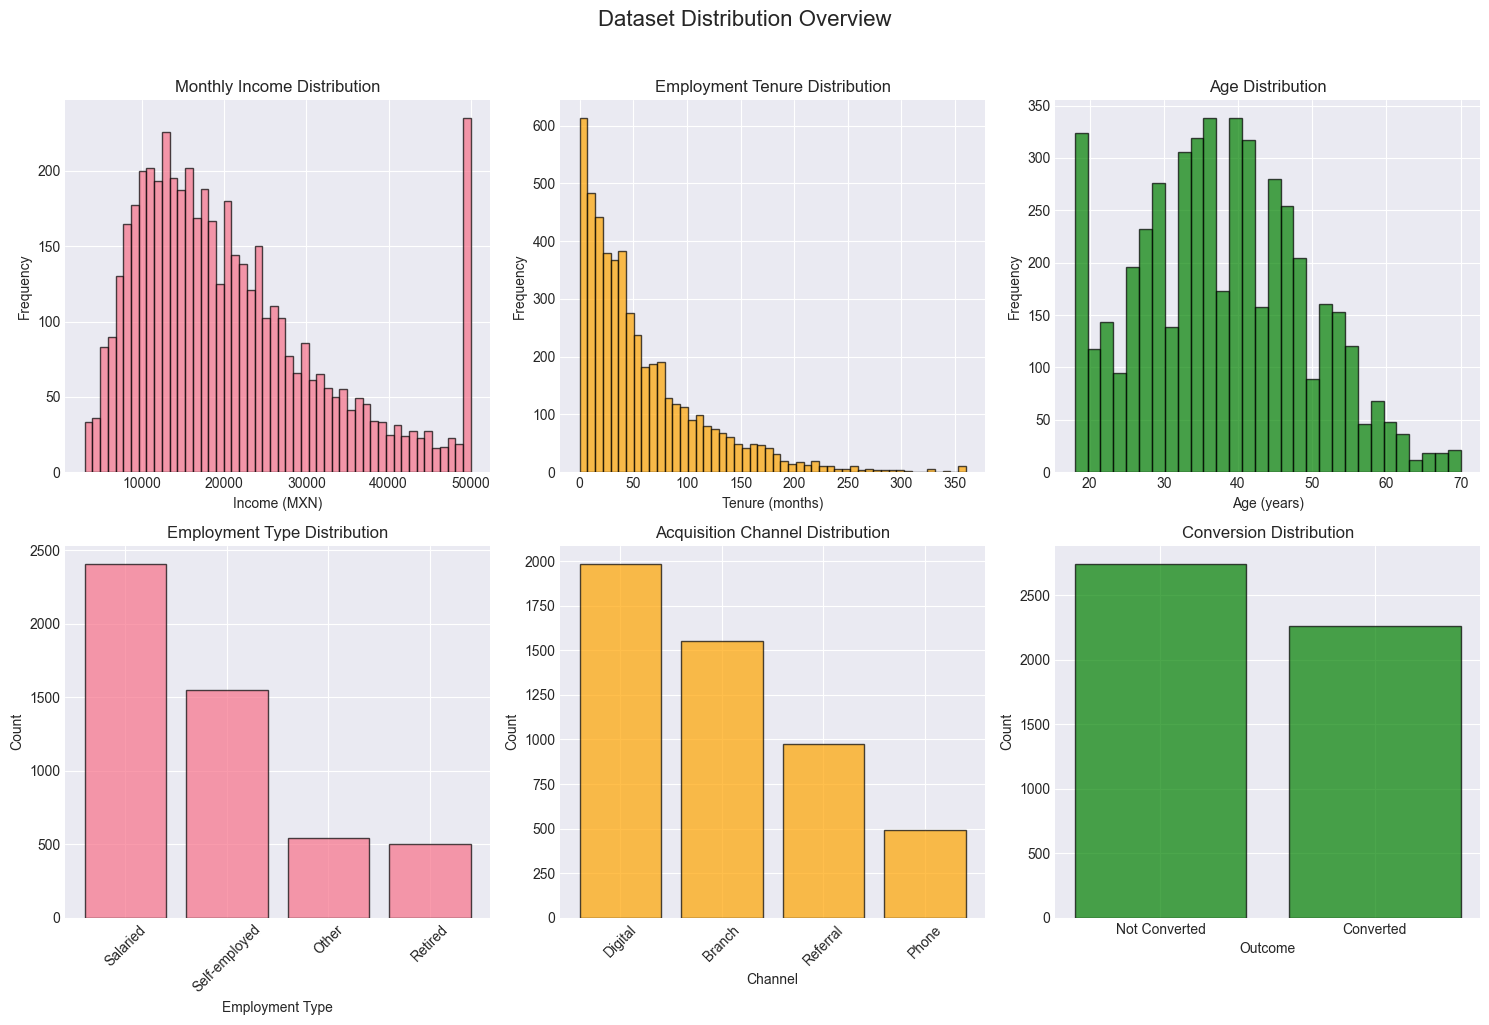

In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Dataset Distribution Overview', fontsize=16, y=1.02)

# Income distribution
axes[0, 0].hist(df['monthly_income'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Monthly Income Distribution')
axes[0, 0].set_xlabel('Income (MXN)')
axes[0, 0].set_ylabel('Frequency')

# Tenure distribution
axes[0, 1].hist(df['employment_tenure'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Employment Tenure Distribution')
axes[0, 1].set_xlabel('Tenure (months)')
axes[0, 1].set_ylabel('Frequency')

# Age distribution
axes[0, 2].hist(df['age'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_title('Age Distribution')
axes[0, 2].set_xlabel('Age (years)')
axes[0, 2].set_ylabel('Frequency')

# Employment type
employment_counts = df['employment_type'].value_counts()
axes[1, 0].bar(employment_counts.index, employment_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Employment Type Distribution')
axes[1, 0].set_xlabel('Employment Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Acquisition channel
channel_counts = df['acquisition_channel'].value_counts()
axes[1, 1].bar(channel_counts.index, channel_counts.values, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Acquisition Channel Distribution')
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Conversion rate
conversion_counts = df['converted'].value_counts()
axes[1, 2].bar(['Not Converted', 'Converted'], conversion_counts.values, edgecolor='black', alpha=0.7, color='green')
axes[1, 2].set_title('Conversion Distribution')
axes[1, 2].set_xlabel('Outcome')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 5. Analyze Conversion Rates by Feature

In [6]:
# Conversion rate by employment type
print("Conversion rate by employment type:")
conv_by_employment = df.groupby('employment_type')['converted'].agg(['mean', 'count'])
conv_by_employment.columns = ['Conversion Rate', 'Count']
conv_by_employment['Conversion Rate'] = conv_by_employment['Conversion Rate'].apply(lambda x: f"{x:.2%}")
display(conv_by_employment.sort_values('Count', ascending=False))

print("\nConversion rate by acquisition channel:")
conv_by_channel = df.groupby('acquisition_channel')['converted'].agg(['mean', 'count'])
conv_by_channel.columns = ['Conversion Rate', 'Count']
conv_by_channel['Conversion Rate'] = conv_by_channel['Conversion Rate'].apply(lambda x: f"{x:.2%}")
display(conv_by_channel.sort_values('Count', ascending=False))

print("\nConversion rate by marital status:")
conv_by_marital = df.groupby('marital_status')['converted'].agg(['mean', 'count'])
conv_by_marital.columns = ['Conversion Rate', 'Count']
conv_by_marital['Conversion Rate'] = conv_by_marital['Conversion Rate'].apply(lambda x: f"{x:.2%}")
display(conv_by_marital.sort_values('Count', ascending=False))

print("\nConversion rate by gender:")
conv_by_gender = df.groupby('gender')['converted'].agg(['mean', 'count'])
conv_by_gender.columns = ['Conversion Rate', 'Count']
conv_by_gender['Conversion Rate'] = conv_by_gender['Conversion Rate'].apply(lambda x: f"{x:.2%}")
display(conv_by_gender)

Conversion rate by employment type:


,Conversion Rate,Count
employment_type,,
Salaried,60.66%,2410
Self-employed,48.87%,1547
Other,43.15%,540
Retired,58.05%,503



Conversion rate by acquisition channel:


,Conversion Rate,Count
acquisition_channel,,
Digital,53.42%,1986
Branch,56.00%,1550
Referral,61.46%,973
Phone,43.99%,491



Conversion rate by marital status:


,Conversion Rate,Count
marital_status,,
Married,55.22%,2202
Single,53.12%,1811
Divorced,57.26%,737
Widowed,57.20%,250



Conversion rate by gender:


,Conversion Rate,Count
gender,,
F,55.57%,2406
M,54.20%,2594


## 6. Create Income Bins for Analysis

In [7]:
# Create income bins matching the example in the document
income_bins = [0, 8000, 15000, 25000, 40000, 50001]
income_labels = ['0-8K', '8K-15K', '15K-25K', '25K-40K', '40K+']

df['income_bin'] = pd.cut(
    df['monthly_income'],
    bins=income_bins,
    labels=income_labels,
    include_lowest=True
)

# Analyze conversion by income bin
print("Conversion analysis by income bin:")
income_analysis = df.groupby('income_bin', observed=True).agg({
    'converted': ['count', 'sum', 'mean']
}).round(3)

income_analysis.columns = ['Total Leads', 'Converted', 'Conversion Rate']
income_analysis['Not Converted'] = income_analysis['Total Leads'] - income_analysis['Converted']
income_analysis = income_analysis[['Total Leads', 'Converted', 'Not Converted', 'Conversion Rate']]
income_analysis['Conversion Rate'] = income_analysis['Conversion Rate'].apply(lambda x: f"{x:.1%}")

display(income_analysis)

Conversion analysis by income bin:


,Total Leads,Converted,Not Converted,Conversion Rate
income_bin,,,,
0-8K,433,194,239,44.8%
8K-15K,1440,678,762,47.1%
15K-25K,1666,911,755,54.7%
25K-40K,1004,635,369,63.2%
40K+,457,325,132,71.1%


## 7. Generate Time-Series Data for PSI Analysis

In [8]:
# Generate a second dataset with slightly different distribution
# This simulates population shift over time
np.random.seed(123)

n_samples_prod = 3000

# Generate with shifted distributions
monthly_income_prod = generate_monthly_income(n_samples_prod) * 0.95  # Slightly lower incomes
employment_tenure_prod = generate_employment_tenure(n_samples_prod) * 0.80  # Lower tenure
age_prod = generate_age(n_samples_prod) - 2  # Slightly younger

# Shift channel distribution (more digital, less branch)
acquisition_channel_prod = generate_categorical(
    n_samples_prod,
    categories=['Digital', 'Branch', 'Referral', 'Phone'],
    probabilities=[0.55, 0.20, 0.15, 0.10]  # Changed from [0.40, 0.30, 0.20, 0.10]
)

employment_type_prod = generate_categorical(
    n_samples_prod,
    categories=['Salaried', 'Self-employed', 'Retired', 'Other'],
    probabilities=[0.50, 0.30, 0.10, 0.10]
)

marital_status_prod = generate_categorical(
    n_samples_prod,
    categories=['Single', 'Married', 'Divorced', 'Widowed'],
    probabilities=[0.35, 0.45, 0.15, 0.05]
)

gender_prod = generate_categorical(
    n_samples_prod,
    categories=['M', 'F'],
    probabilities=[0.52, 0.48]
)

# Calculate conversion
conversion_probs_prod = calculate_conversion_probability(
    monthly_income_prod,
    employment_tenure_prod,
    age_prod,
    employment_type_prod,
    acquisition_channel_prod
)

converted_prod = generate_conversion(conversion_probs_prod)

# Create production DataFrame
df_prod = pd.DataFrame({
    'monthly_income': monthly_income_prod,
    'employment_tenure': employment_tenure_prod,
    'age': age_prod,
    'employment_type': employment_type_prod,
    'acquisition_channel': acquisition_channel_prod,
    'marital_status': marital_status_prod,
    'gender': gender_prod,
    'converted': converted_prod
})

print(f"Production dataset shape: {df_prod.shape}")
print(f"Production conversion rate: {df_prod['converted'].mean():.2%}")

Production dataset shape: (3000, 8)
Production conversion rate: 50.77%


## 8. Save Datasets

In [10]:
# Create output directory if it doesn't exist
import os

output_dir = '../data/raw'
os.makedirs(output_dir, exist_ok=True)

# Save development dataset
dev_path = os.path.join(output_dir, 'lead_conversion_development.csv')
df.to_csv(dev_path, index=False)
print(f"Development dataset saved to: {dev_path}")

# Save production dataset
prod_path = os.path.join(output_dir, 'lead_conversion_production.csv')
df_prod.to_csv(prod_path, index=False)
print(f"Production dataset saved to: {prod_path}")

print("\n✓ Datasets generated successfully!")

Development dataset saved to: ../data/raw/lead_conversion_development.csv
Production dataset saved to: ../data/raw/lead_conversion_production.csv

✓ Datasets generated successfully!


## Summary

We have successfully generated two synthetic datasets:

1. **Development Dataset** (5,000 records): Used for model development and initial analysis
2. **Production Dataset** (3,000 records): Used for PSI analysis and monitoring

The datasets include:
- Realistic distributions for all variables
- Meaningful relationships between features and conversion
- Population shift in the production dataset (for PSI demonstration)

Key characteristics:
- Overall conversion rate: ~25-30%
- Strong predictors: monthly_income, employment_tenure, acquisition_channel
- Weak predictors: gender, marital_status

These datasets are now ready to be used in the next notebook for demonstrating all credit scoring metrics and transformations.